# exploring my dataset using clustering - affinity propagation
http://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#example-cluster-plot-affinity-propagation-py

In [11]:
import numpy as np
import pandas as pd
import psycopg2

In [14]:
conn = psycopg2.connect("dbname='indicators'")
cursor = conn.cursor()

In [31]:
query = """SELECT country, indicator, zscore from indicators;"""
cursor.execute(query)

In [32]:
df0 = pd.DataFrame(cursor.fetchall(),
		  columns=[desc[0] for desc in cursor.description])

In [60]:
selected = df0['indicator'].sample(5)
df = (df0[(df0.indicator.isin(selected))]
      .pivot(index='country', columns = 'indicator', values='zscore'))
df.fillna(0, inplace=True)

In [118]:
query = """SELECT indicator, label_short from metadata"""
cursor.execute(query)
indicator_labels = pd.DataFrame(cursor.fetchall(),
				columns=[desc[0] for desc in cursor.description])

In [125]:
i_labs = indicator_labels[(indicator_labels.indicator.isin(selected))]

In [121]:
conn.close()

In [120]:
df.head()

indicator    BRIBEIDX   EOSQ048  EOSQ050  NV.IND.MANF.ZS  SG.GEN.LSOM.ZS
country                                                                 
Afghanistan  0.000000  0.000000  0.00000        0.062218        0.000000
Albania     -0.788235  0.821267 -0.76861       -0.878490       -0.586303
Algeria     -1.001360 -0.576364 -1.41979        0.000000       -1.581120
Andorra      0.000000  0.000000  0.00000       -1.215450        0.000000
Angola      -1.470030 -1.181890 -2.43313        0.000000        0.000000

In [127]:
i_labs

         indicator                                        label_short
44  NV.IND.MANF.ZS                         Manufacturing, value added
49  SG.GEN.LSOM.ZS  Female legislators, senior officials and managers
65        BRIBEIDX                      Irregular payments and bribes
81         EOSQ048                    Burden of government regulation
83         EOSQ050                       Burden of customs procedures

# CLUSTER THESE with Affinity Propagation

In [56]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [0]:
X = np.array(df)
labels_true = df.index

In [70]:
print X[:4]
print labels_true

[[ 0.         0.         0.         0.0622179  0.       ]
 [-0.788235   0.821267  -0.76861   -0.87849   -0.586303 ]
 [-1.00136   -0.576364  -1.41979    0.        -1.58112  ]
 [ 0.         0.         0.        -1.21545    0.       ]]
Index([u'Afghanistan', u'Albania', u'Algeria', u'Andorra', u'Angola',
       u'Antigua and Barbuda', u'Argentina', u'Armenia', u'Aruba',
       u'Australia',
       ...
       u'United States', u'Uruguay', u'Uzbekistan', u'Vanuatu', u'Venezuela',
       u'Vietnam', u'West Bank and Gaza', u'Yemen', u'Zambia', u'Zimbabwe'],
      dtype='object', name=u'country', length=197)


In [0]:
af = AffinityPropagation().fit(X)

In [72]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [73]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Homogeneity: %0.3f' % metrics.homogeneity_score(labels_true, labels))
print('Completeness: %0.3f' % metrics.completeness_score(labels_true, labels))
print('V-measure: %0.3f' % metrics.v_measure_score(labels_true, labels))
print('Adjusted Rand Index: %0.3f' % metrics.adjusted_rand_score(
    labels_true, labels))
print('Adjusted Mutual Information %0.3f' %
      metrics.adjusted_mutual_info_score(labels_true, labels))
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(
    X, labels, metric='sqeuclidean'))

Estimated number of clusters: 21
Homogeneity: 0.536
Completeness: 1.000
V-measure: 0.698
Adjusted Rand Index: 0.000
Adjusted Mutual Information 0.000
Silhouette Coefficient: 0.429


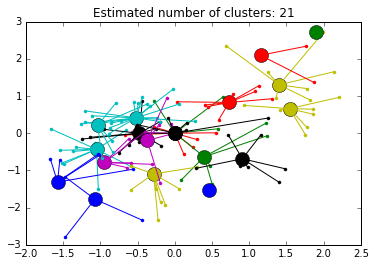

/Users/pawel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [74]:
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)    

In [131]:
# print members of a cluster (from 0 to 20)
k = 10
class_members=(labels==k)
print "Selected indicators:"
print selected.values
print "\nIndicator labels:"
print i_labs
print "\nCluster members (k = %i):" % k
print labels_true[class_members]

Selected indicators:
['EOSQ048' 'SG.GEN.LSOM.ZS' 'EOSQ050' 'NV.IND.MANF.ZS' 'BRIBEIDX']

Indicator labels:
         indicator                                        label_short
44  NV.IND.MANF.ZS                         Manufacturing, value added
49  SG.GEN.LSOM.ZS  Female legislators, senior officials and managers
65        BRIBEIDX                      Irregular payments and bribes
81         EOSQ048                    Burden of government regulation
83         EOSQ050                       Burden of customs procedures

Cluster members (k = 10):
Index([u'Armenia', u'Bolivia', u'Burkina Faso', u'Cameroon', u'Cape Verde',
       u'Cote d'Ivoire', u'Guyana', u'Kenya', u'Lao PDR', u'Lesotho',
       u'Malawi', u'Mozambique', u'Paraguay', u'Senegal', u'Seychelles',
       u'Tajikistan', u'Uganda', u'Zambia'],
      dtype='object', name=u'country')


In [102]:
print class_members
print sum(class_members)
print labels

[False False False False  True False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [78]:
cluster_centers_indices

array([  6,   8,  25,  28,  41,  57,  75,  98, 102, 105, 107, 117, 136,
       139, 140, 141, 144, 172, 173, 186, 193])

In [94]:
labels_true

Index([u'Afghanistan', u'Albania', u'Algeria', u'Andorra', u'Angola',
       u'Antigua and Barbuda', u'Argentina', u'Armenia', u'Aruba',
       u'Australia',
       ...
       u'United States', u'Uruguay', u'Uzbekistan', u'Vanuatu', u'Venezuela',
       u'Vietnam', u'West Bank and Gaza', u'Yemen', u'Zambia', u'Zimbabwe'],
      dtype='object', name=u'country', length=197)